In [150]:
import pandas as pan
pan.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Pre-processing

### Joining data

In [31]:
raw_tx_features = pan.read_csv('tx_features_extract.csv')
raw_tx_in_features = pan.read_csv('tx_in_features.csv')
raw_tx_out_features = pan.read_csv('tx_out_features.csv')
raw_tx_rate_features = pan.read_csv('transaction_rate_features.csv')
address_labels = pan.read_csv('address-labels.csv')

In [32]:
merged_tx_in_tx_out = pan.merge(left= raw_tx_out_features, right= raw_tx_in_features, how="inner", on="address")
merged_tx_in_tx_out_tx = pan.merge(left= merged_tx_in_tx_out, right= raw_tx_features, how="inner", on="address")
merged_tx_rate = pan.merge(left= merged_tx_in_tx_out_tx, right= raw_tx_rate_features, how="inner", on="address")
raw_features = pan.merge(left= merged_tx_rate, right= address_labels, how="inner", on="address")

## Adding new features

### Adding transactions fee feature

In [33]:
raw_features['tx_fee'] = raw_features['sum_spent'] - raw_features['sum_granted']

### difference between outputs and inputs counts

In [34]:
raw_features['diff_in_out_count'] = raw_features['address_out_count'] - raw_features['address_in_count']

### ratio of outputs and input counts/values

In [35]:
raw_features['ratio_in_out_count'] = raw_features['address_in_count'] / raw_features['address_out_count']
raw_features['ratio_in_out_values'] = raw_features['sum_granted'] / raw_features['sum_spent']

### Input/output Min/Max difference

In [36]:
raw_features['range_spent'] = raw_features['max_spent'] - raw_features['min_spent']
raw_features['range_granted'] = raw_features['max_granted'] - raw_features['min_granted']

### Input/Output Range to Sum Ratio

In [37]:
raw_features['ratio_range_to_value_output'] = raw_features.range_spent / raw_features.sum_spent 
raw_features['ratio_range_to_value_input'] = raw_features.range_granted / raw_features.sum_granted

### Input/Output Index Range

In [38]:
raw_features['range_output_index'] = raw_features['max_output_index'] - raw_features['min_output_index']
raw_features['range_input_index'] = raw_features['max_input_index'] - raw_features['min_input_index']

### Life Period

In [39]:
raw_features['life_period'] = raw_features['first_time_tx'] - raw_features['last_time_tx']

### Transaction-based Range

In [40]:
raw_features['range_tx_size'] = raw_features['tx_size_max'] - raw_features['tx_size_min']
raw_features['range_tx_num_of_out'] = raw_features['tx_num_of_out_max'] - raw_features['tx_num_of_out_min']
raw_features['range_tx_num_of_inp'] = raw_features['tx_num_of_inp_max'] - raw_features['tx_num_of_inp_min']

In [41]:
raw_features = raw_features.reset_index()
raw_features = raw_features.drop('index', axis=1)

### Reorder columns

In [42]:
cols = list(raw_features.columns)
sw_index = cols.index('SW')
label_index = cols.index('label')
range_inp_index = cols.index('range_tx_num_of_inp')
range_out_index = cols.index('range_tx_num_of_out')
cols[sw_index], cols[range_out_index] = cols[range_out_index], cols[sw_index]
cols[label_index], cols[range_inp_index] = cols[range_inp_index], cols[label_index]
raw_features = raw_features[cols]

### making dataset for strongly addressed labels

In [43]:
strongly_addressed_features = raw_features.loc[raw_features['SW'] == 'SA']
strongly_addressed_features.label.value_counts()

Centralized Exchange                    31252
Gambling                                10729
Cyber-Security Service                  10581
Tumbler                                  1414
Darknet Market                           1226
P2P Financial Service                     924
Mining Pool                               114
P2P Financial Infrastructure Service       29
Individual Wallet                           4
Government Criminal Blacklist               2
Ponzi Scheme                                2
Name: label, dtype: int64

### removing unbalanced labels

In [45]:
strongly_addressed_features = strongly_addressed_features.loc[
    (strongly_addressed_features['label'] != 'Government Criminal Blacklist') & 
    (strongly_addressed_features['label'] != 'Ponzi Scheme') &
    (strongly_addressed_features['label'] != 'Individual Wallet') &
    (strongly_addressed_features['label'] != 'P2P Financial Infrastructure Service')]
strongly_addressed_features = strongly_addressed_features.reset_index()
strongly_addressed_features = strongly_addressed_features.drop(['SW', 'index'], axis=1)

In [46]:
strongly_addressed_features.label.value_counts()

Centralized Exchange      31252
Gambling                  10729
Cyber-Security Service    10581
Tumbler                    1414
Darknet Market             1226
P2P Financial Service       924
Mining Pool                 114
Name: label, dtype: int64

### Address Distribution

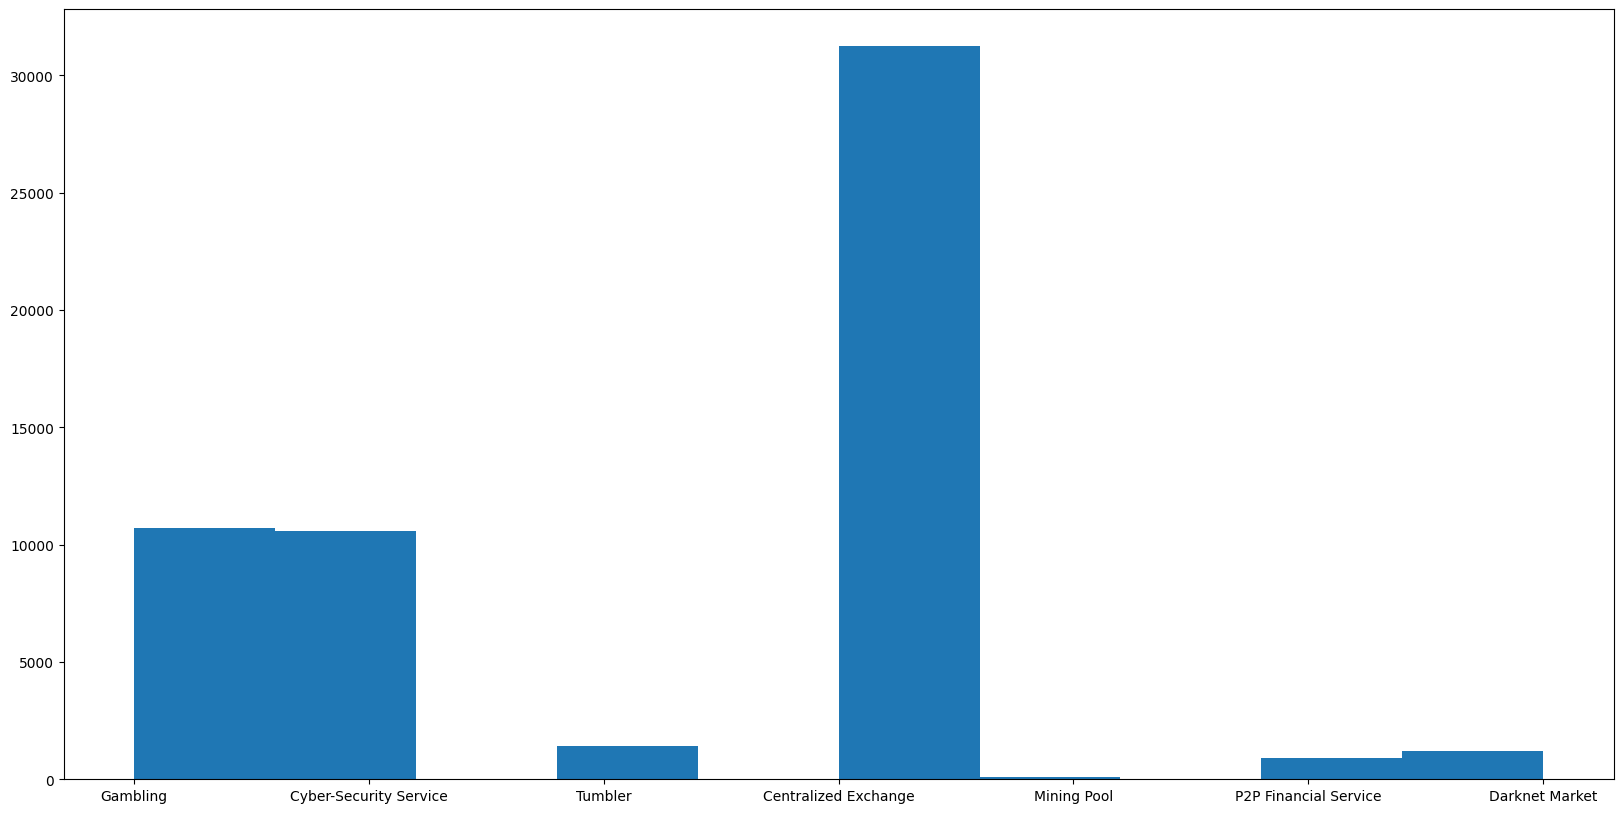

In [49]:
ax = strongly_addressed_features.label.hist(figsize=(20, 10), grid=False)

## Training Phase

In [51]:
train_test_data = pan.read_csv('prepared-features.csv')

In [52]:
train_test_features = train_test_data.drop(['address', 'label'], axis=1)
train_test_labels = train_test_data['label']

In [53]:
train_features, test_features, train_labels, test_labels = train_test_split(train_test_features, 
                            train_test_labels, train_size=0.6, random_state=111, stratify=train_test_labels)

### On Weak+strongly labeled data

#### Using Decision tree classifier

In [264]:
clf = DecisionTreeClassifier(random_state=None)
cross_val_score(clf, train_features, train_labels, cv=8)

array([0.95594406, 0.96223776, 0.96433566, 0.95477855, 0.95757576,
       0.9568664 , 0.95709956, 0.95989741])

In [265]:
clf.fit(train_features, train_labels)
predicted_labels = clf.predict(test_features)

In [266]:
accuracy_score(test_labels, predicted_labels)

0.9621486953101097

In [267]:
f1_score(test_labels, predicted_labels, average=None)

array([0.46732673, 0.98899604, 0.94667451, 0.89361702, 0.97226107,
       0.112     , 0.97777778, 0.57142857, 0.93296854, 0.82076237])

In [268]:
recall_score(test_labels, predicted_labels, average=None)

array([0.45914397, 0.98856092, 0.95014178, 0.9       , 0.97180801,
       0.11666667, 0.95652174, 0.5       , 0.92162162, 0.8174475 ])

In [269]:
precision_score(test_labels, predicted_labels, average=None)

array([0.47580645, 0.98943155, 0.94323247, 0.88732394, 0.97271455,
       0.10769231, 1.        , 0.66666667, 0.94459834, 0.82410423])

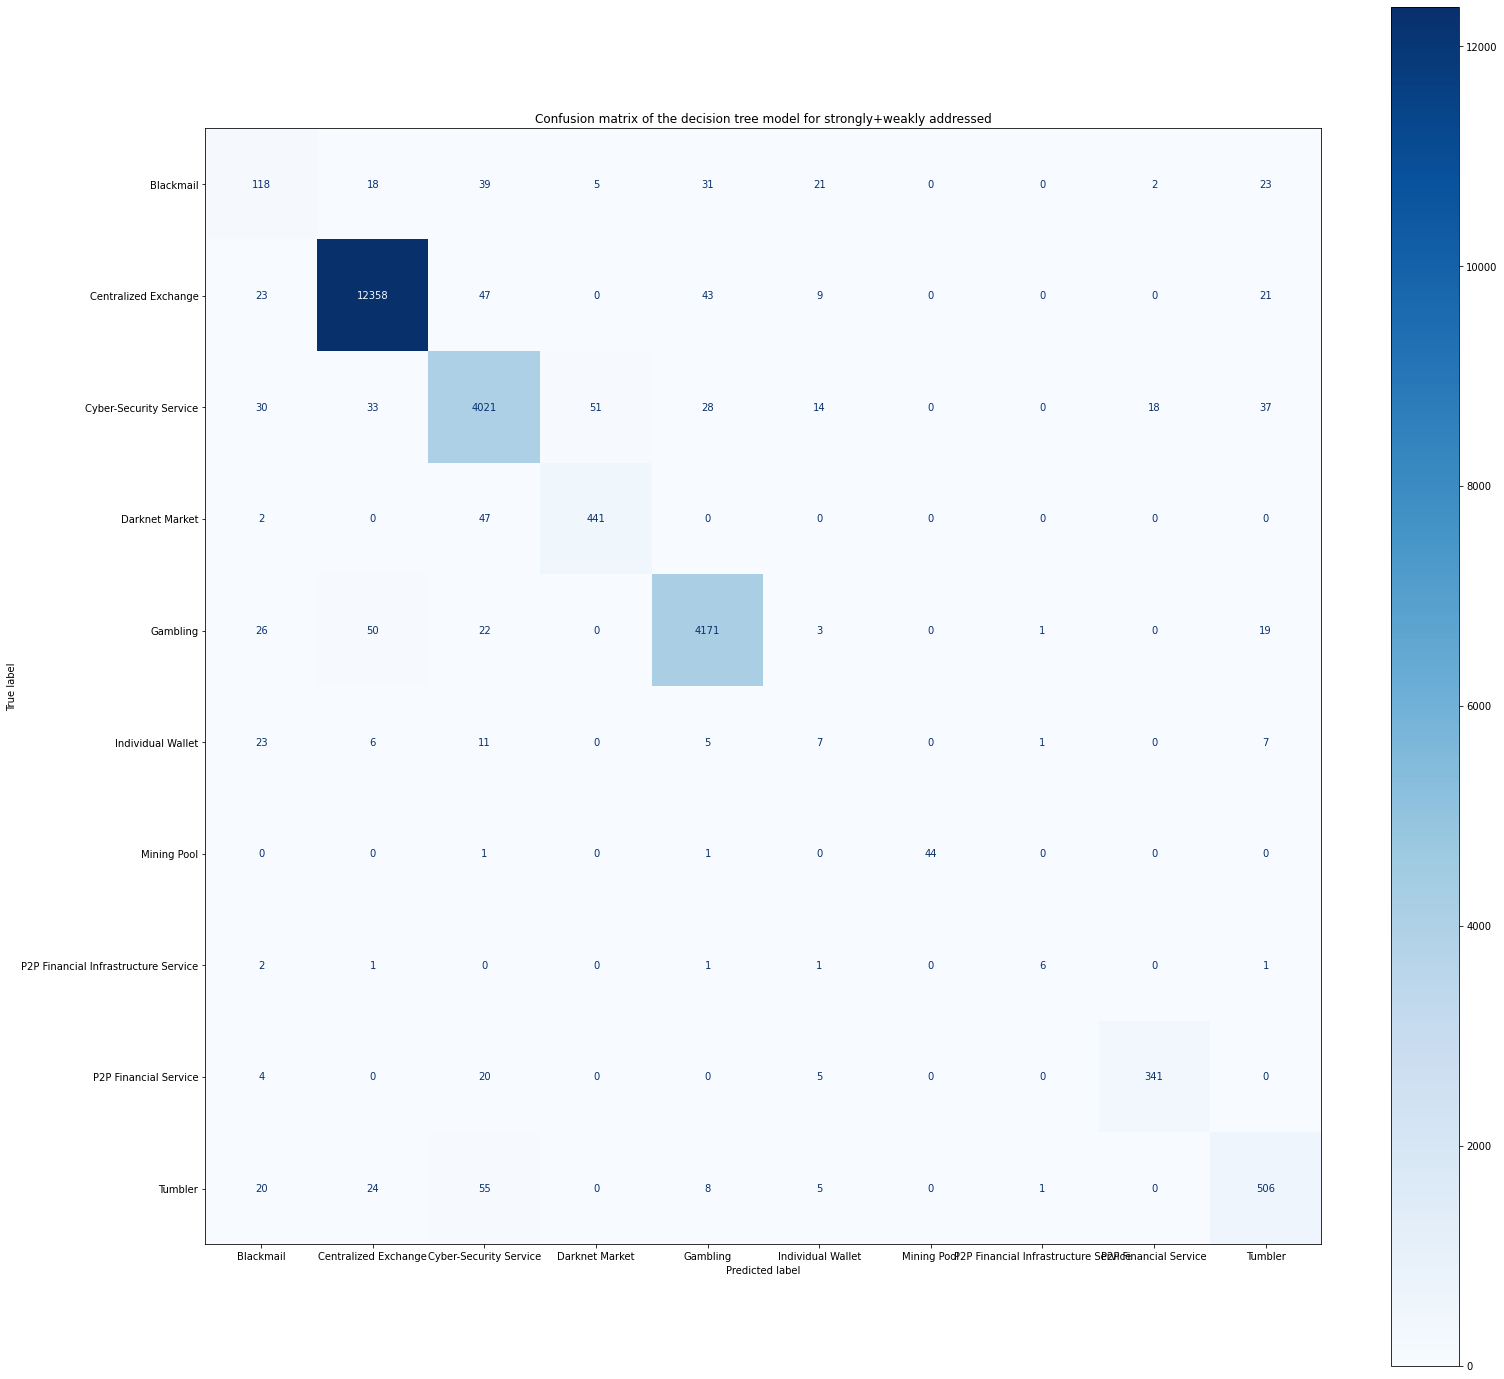

In [270]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the decision tree model for strongly+weakly addressed")
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    test_features,
    test_labels,
    cmap=plt.cm.Blues,
    ax=ax
)

#### Using Random Forest classifier

In [271]:
dlf = RandomForestClassifier(random_state=None)
cross_val_score(dlf, train_features, train_labels, cv=8)

array([0.97249417, 0.97086247, 0.97365967, 0.97179487, 0.96876457,
       0.97108883, 0.97388669, 0.9722546 ])

In [272]:
dlf.fit(train_features, train_labels)
predicted_labels_forest = dlf.predict(test_features)

In [273]:
accuracy_score(test_labels, predicted_labels_forest)

0.9736439529699724

In [274]:
f1_score(test_labels, predicted_labels_forest, average=None)

array([0.64344262, 0.99300588, 0.9591623 , 0.88482239, 0.98396468,
       0.05797101, 0.97777778, 0.73684211, 0.95145631, 0.87377049])

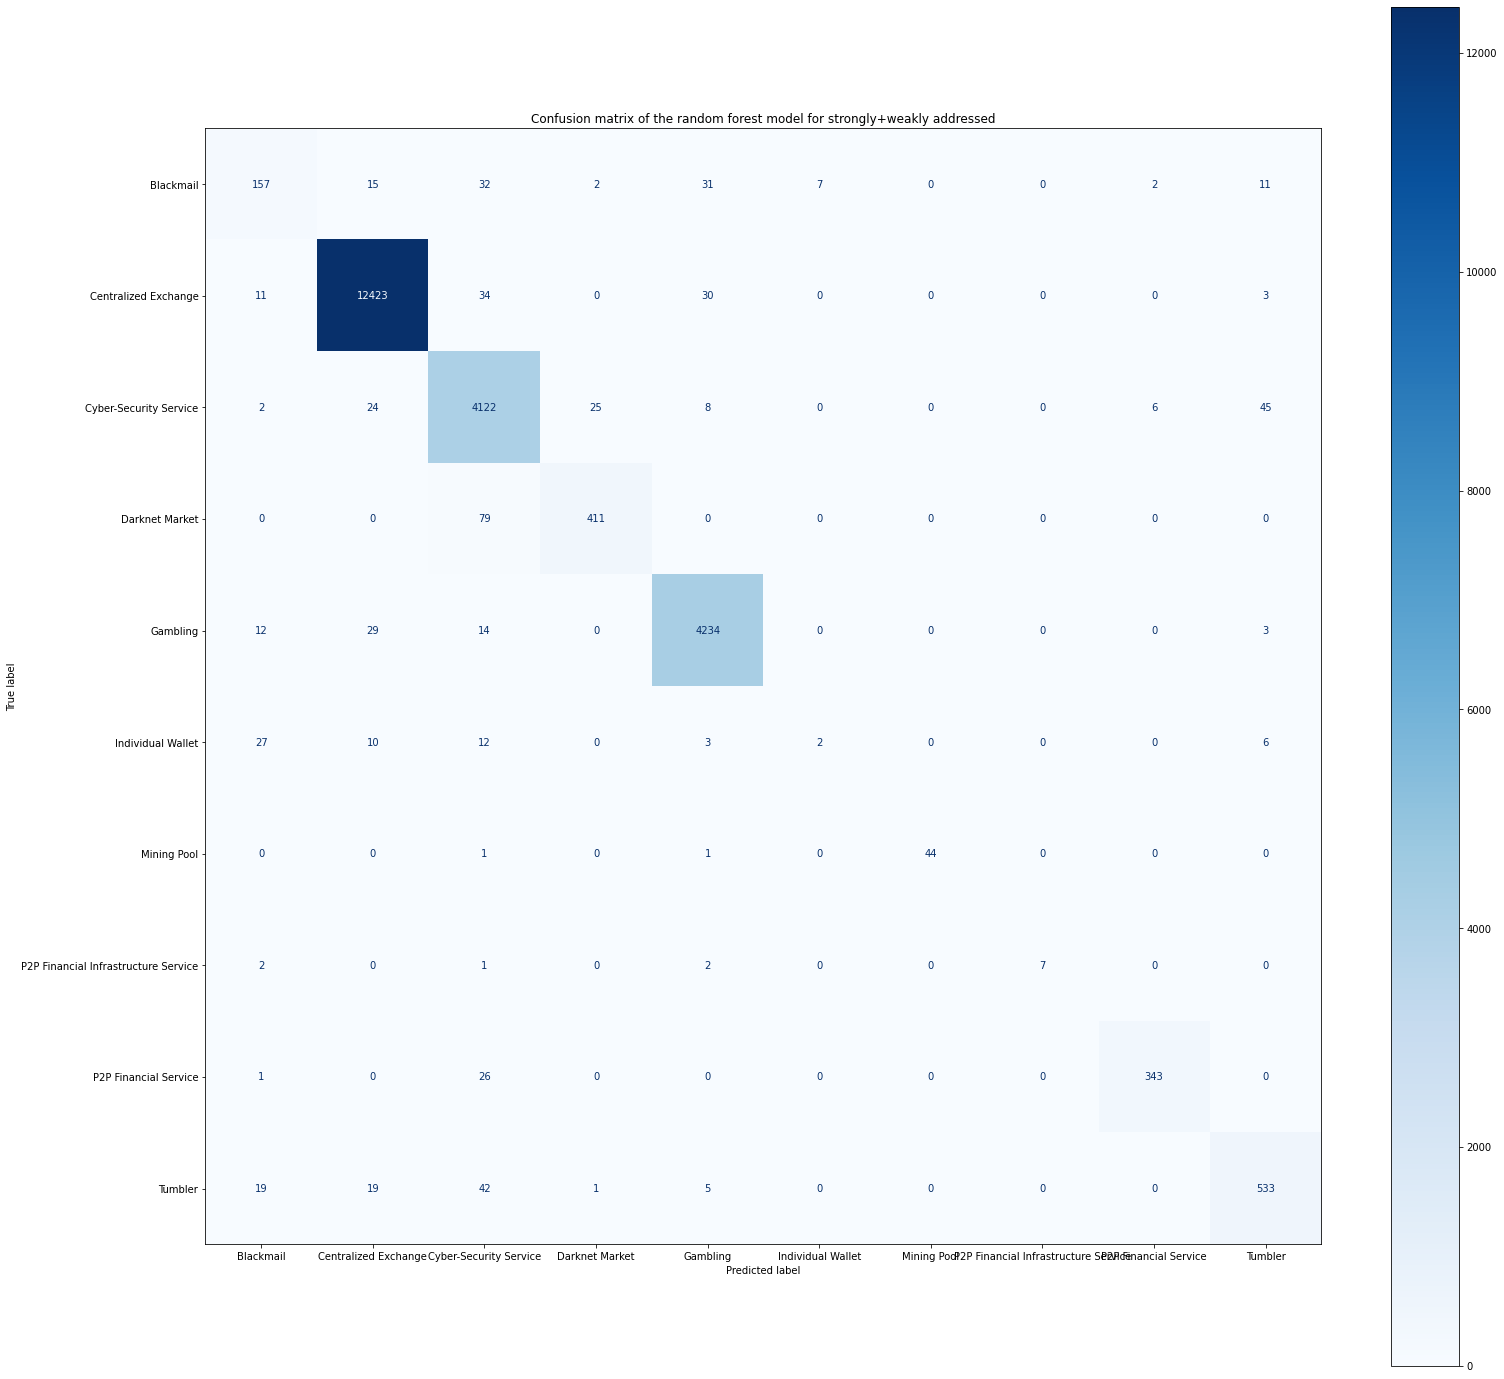

In [275]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the random forest model for strongly+weakly addressed")
disp = ConfusionMatrixDisplay.from_estimator(
    dlf,
    test_features,
    test_labels,
    cmap=plt.cm.Blues,
    ax=ax
)

### ML phase

#### Data Split

In [56]:
train_test_data = pan.read_csv('prepared-features.csv')

In [59]:
train_test_features = train_test_data.drop(['address', 'label'], axis=1)
train_test_labels = train_test_data['label']

In [60]:
train_features, test_features, train_labels, test_labels = train_test_split(train_test_features, 
            train_test_labels, train_size=0.6, random_state=145, stratify=train_test_labels)

#### Using decision tree classifier

In [62]:
clf = DecisionTreeClassifier(random_state=None)
cross_val_score(clf, train_features, train_labels, cv=8)

array([0.96254149, 0.96396396, 0.96609768, 0.96941679, 0.96348981,
       0.96064486, 0.96870555, 0.96135609])

In [63]:
clf.fit(train_features, train_labels)
predicted_labels = clf.predict(test_features)

In [67]:
accuracy_score(test_labels, predicted_labels)

0.9676831436699858

In [68]:
f1_score(test_labels, predicted_labels, average=None)

array([0.98324335, 0.94252602, 0.88704663, 0.97800023, 1.        ,
       0.9218107 , 0.83188908])

In [107]:
f1_score(test_labels, predicted_labels, average='weighted')

0.9677063680751858

In [69]:
recall_score(test_labels, predicted_labels, average=None)

array([0.98336133, 0.94163516, 0.87346939, 0.97879776, 1.        ,
       0.91056911, 0.84805654])

In [70]:
precision_score(test_labels, predicted_labels, average=None)

array([0.9831254 , 0.94341856, 0.90105263, 0.977204  , 1.        ,
       0.93333333, 0.81632653])

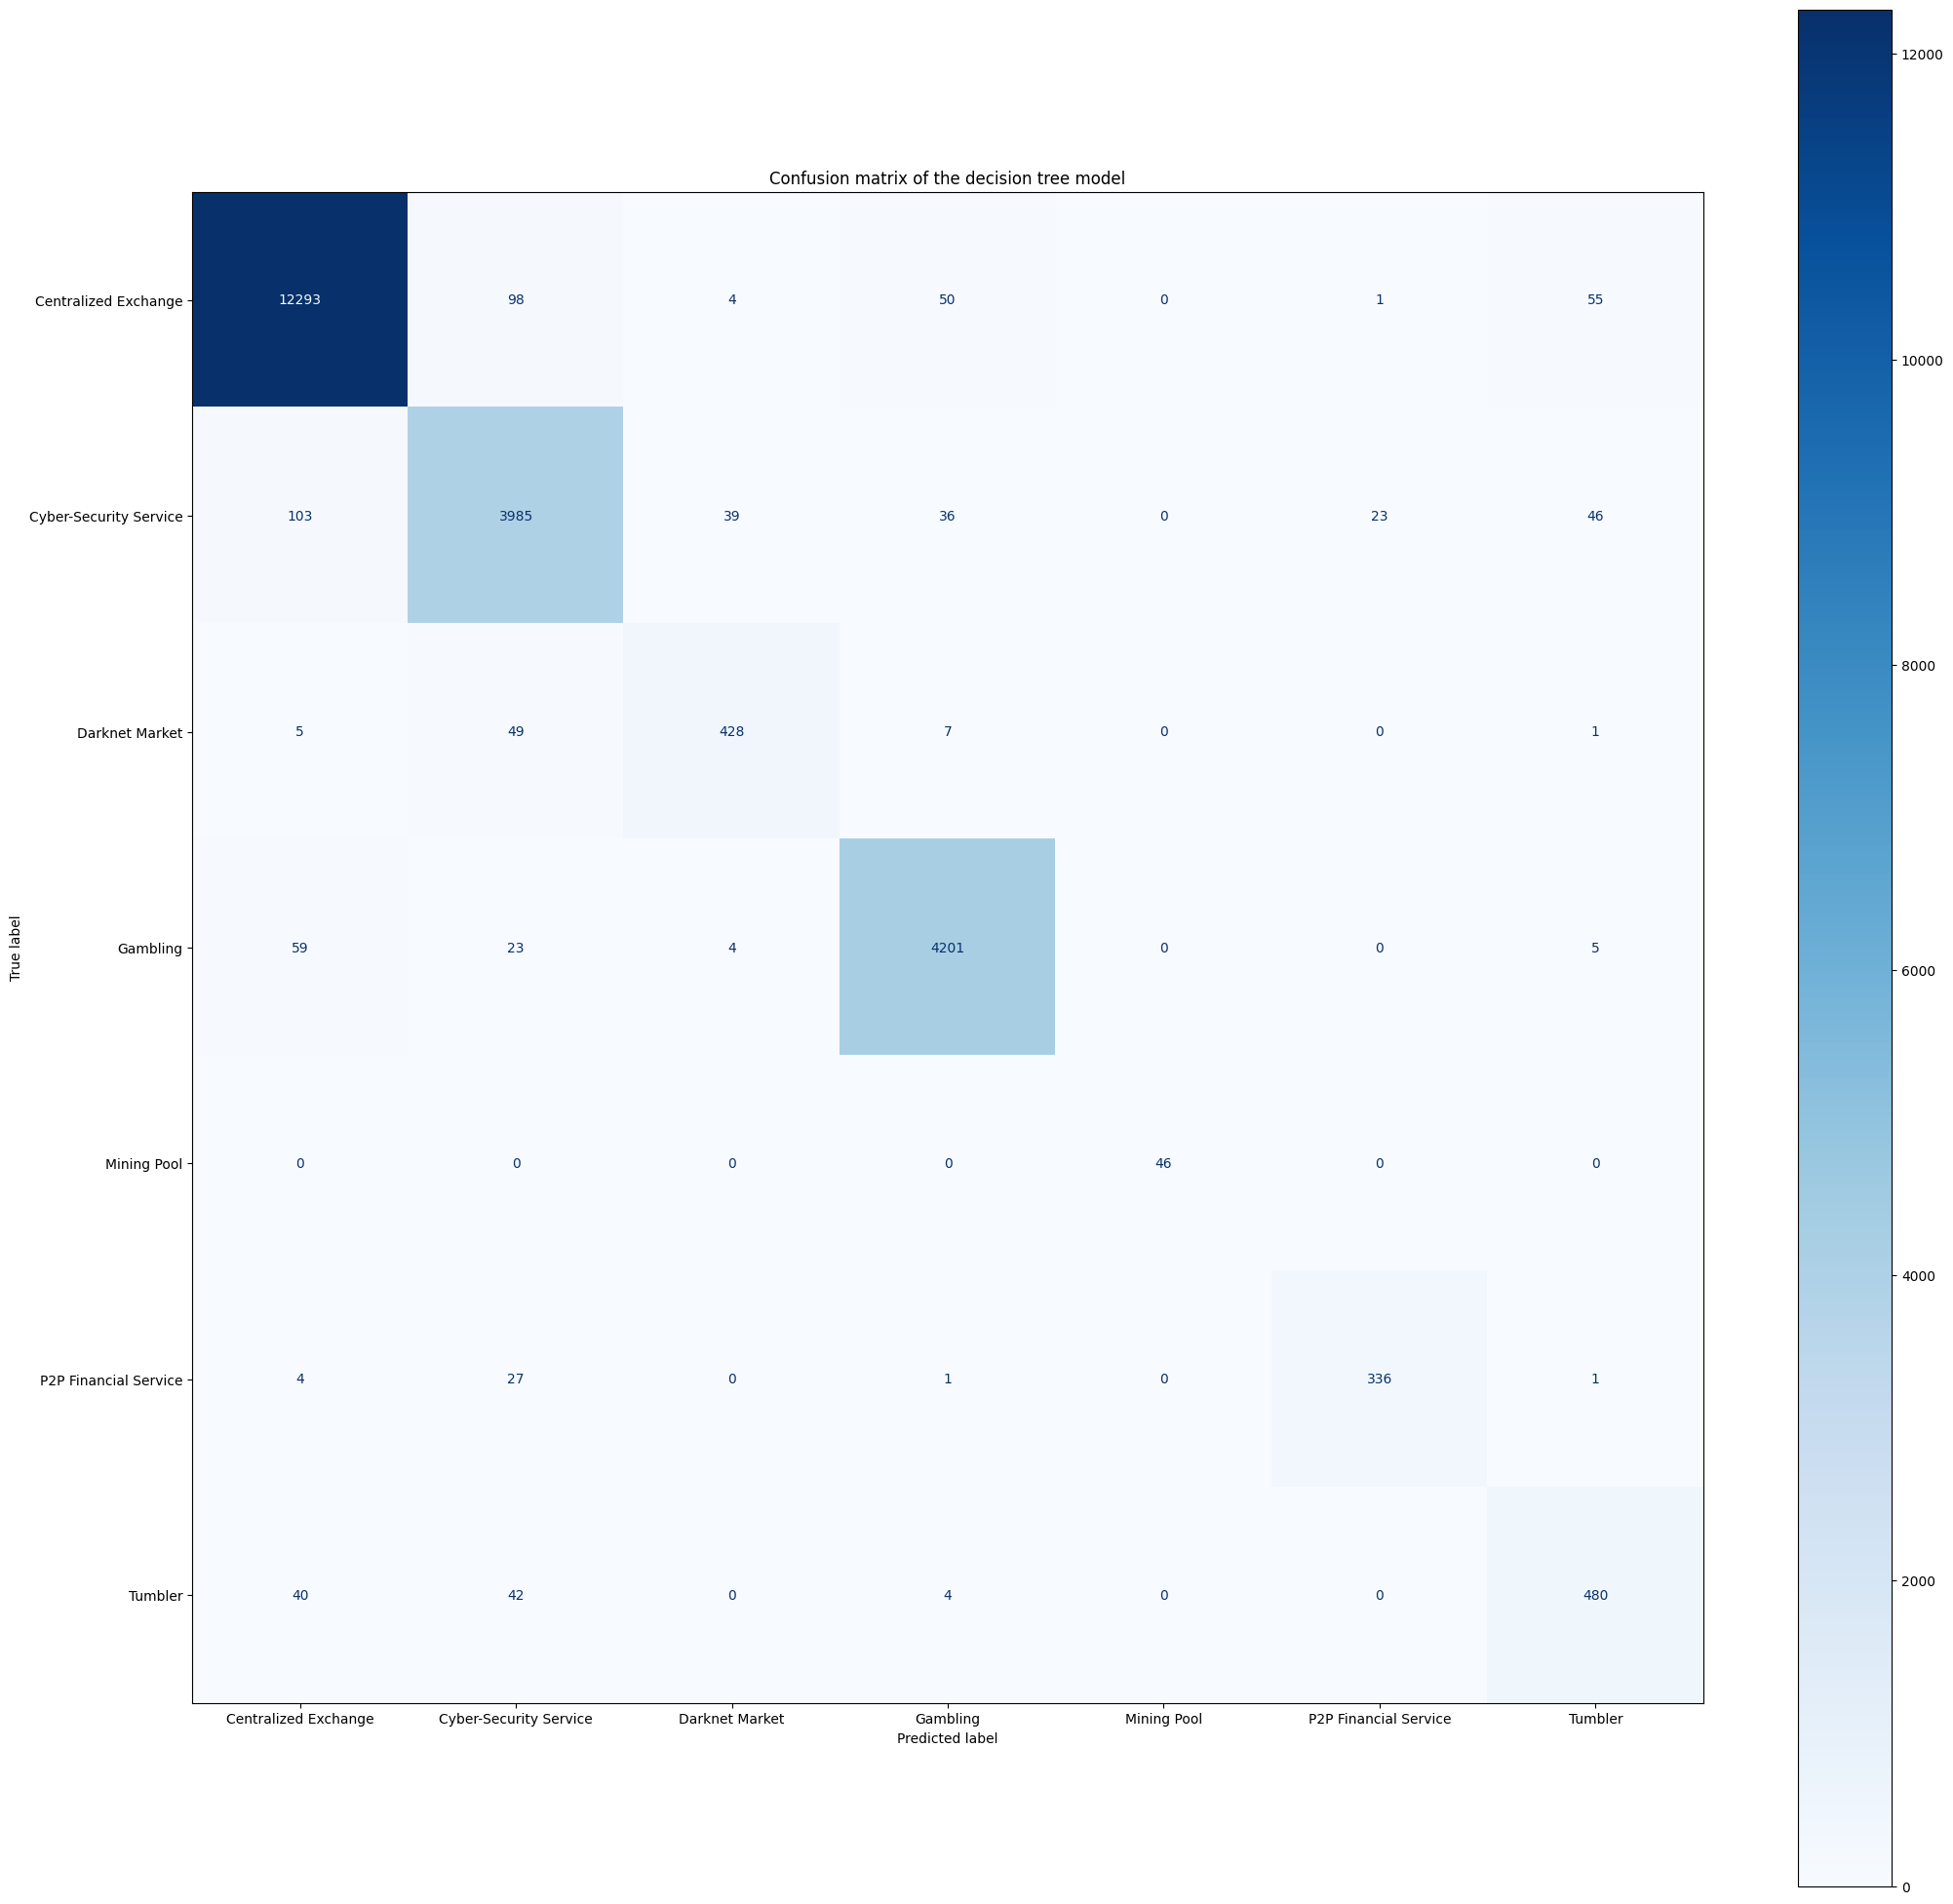

In [109]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the decision tree model")
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    test_features,
    test_labels,
    cmap=plt.cm.Blues,
    ax=ax
)

#### Using random forest classifier

In [73]:
dlf = RandomForestClassifier(random_state=None)
cross_val_score(dlf, train_features, train_labels, cv=8)

array([0.97273589, 0.97392129, 0.97178758, 0.96846847, 0.96894263,
       0.96704599, 0.97012802, 0.97083926])

In [74]:
dlf.fit(train_features, train_labels)
predicted_labels_forest = dlf.predict(test_features)

In [75]:
accuracy_score(test_labels, predicted_labels_forest)

0.97350640113798

In [76]:
f1_score(test_labels, predicted_labels_forest, average=None)

array([0.98832374, 0.95284895, 0.85101822, 0.98269411, 1.        ,
       0.93820225, 0.8554007 ])

In [106]:
f1_score(test_labels, predicted_labels_forest, average='weighted')

0.9734427122502237

In [77]:
recall_score(test_labels, predicted_labels_forest, average=None)

array([0.98856092, 0.96219282, 0.81020408, 0.97903075, 1.        ,
       0.90514905, 0.86749117])

In [78]:
precision_score(test_labels, predicted_labels_forest, average=None)

array([0.98808667, 0.94368482, 0.89616253, 0.98638498, 1.        ,
       0.97376093, 0.84364261])

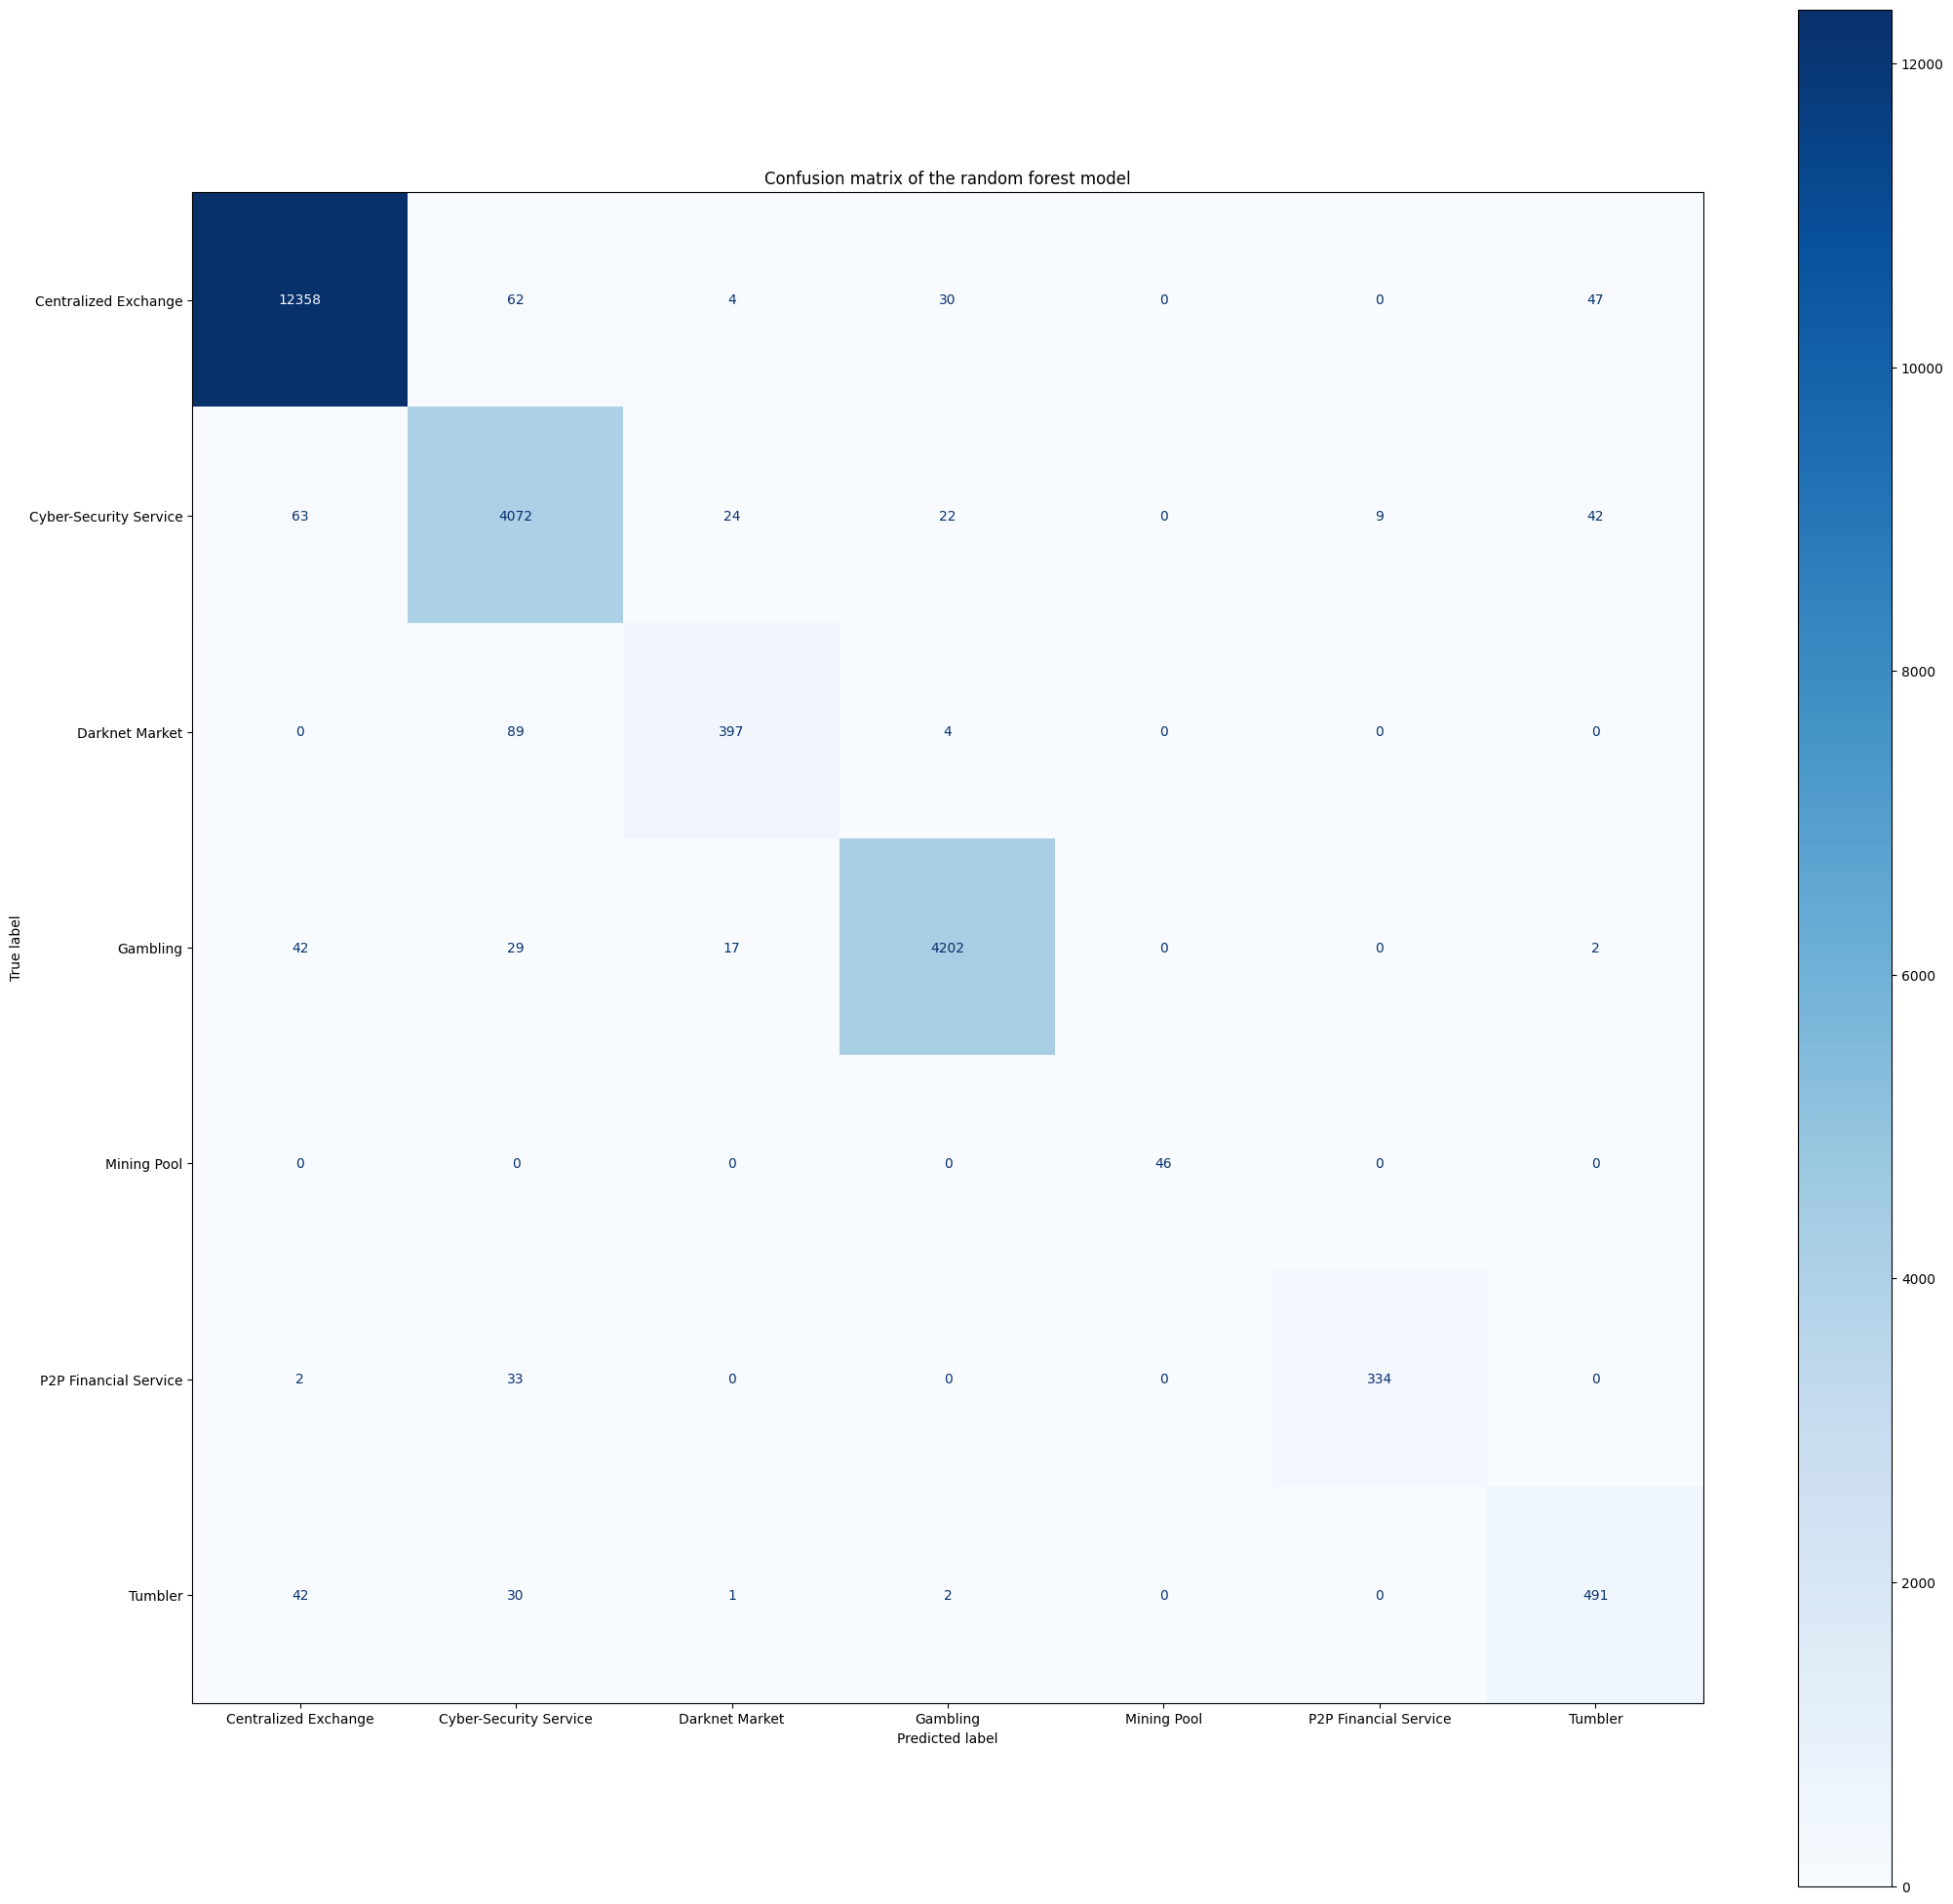

In [108]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the random forest model")
disp = ConfusionMatrixDisplay.from_estimator(
    dlf,
    test_features,
    test_labels,
    cmap=plt.cm.Blues,
    ax=ax
)

#### Using KNN classifier

In [97]:
neigh = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', weights='distance')
cross_val_score(neigh, train_features, train_labels, cv=8)

array([0.70768137, 0.70199147, 0.70317686, 0.70720721, 0.69440493,
       0.68918919, 0.69748696, 0.69914651])

In [98]:
neigh.fit(train_features, train_labels)
predicted_labels_knn = neigh.predict(test_features)

In [99]:
accuracy_score(test_labels, predicted_labels_knn)

0.7063033428165008

In [100]:
f1_score(test_labels, predicted_labels_knn, average=None)

array([0.81281166, 0.45280612, 0.22464558, 0.75318546, 0.35135135,
       0.43057722, 0.14989733])

In [105]:
f1_score(test_labels, predicted_labels_knn, average='weighted')

0.697007000393622

In [102]:
recall_score(test_labels, predicted_labels_knn, average=None)

array([0.8475322 , 0.41942344, 0.21020408, 0.74370923, 0.2826087 ,
       0.37398374, 0.12897527])

In [101]:
precision_score(test_labels, predicted_labels_knn, average=None)

array([0.78082394, 0.49196231, 0.2412178 , 0.76290631, 0.46428571,
       0.50735294, 0.17892157])

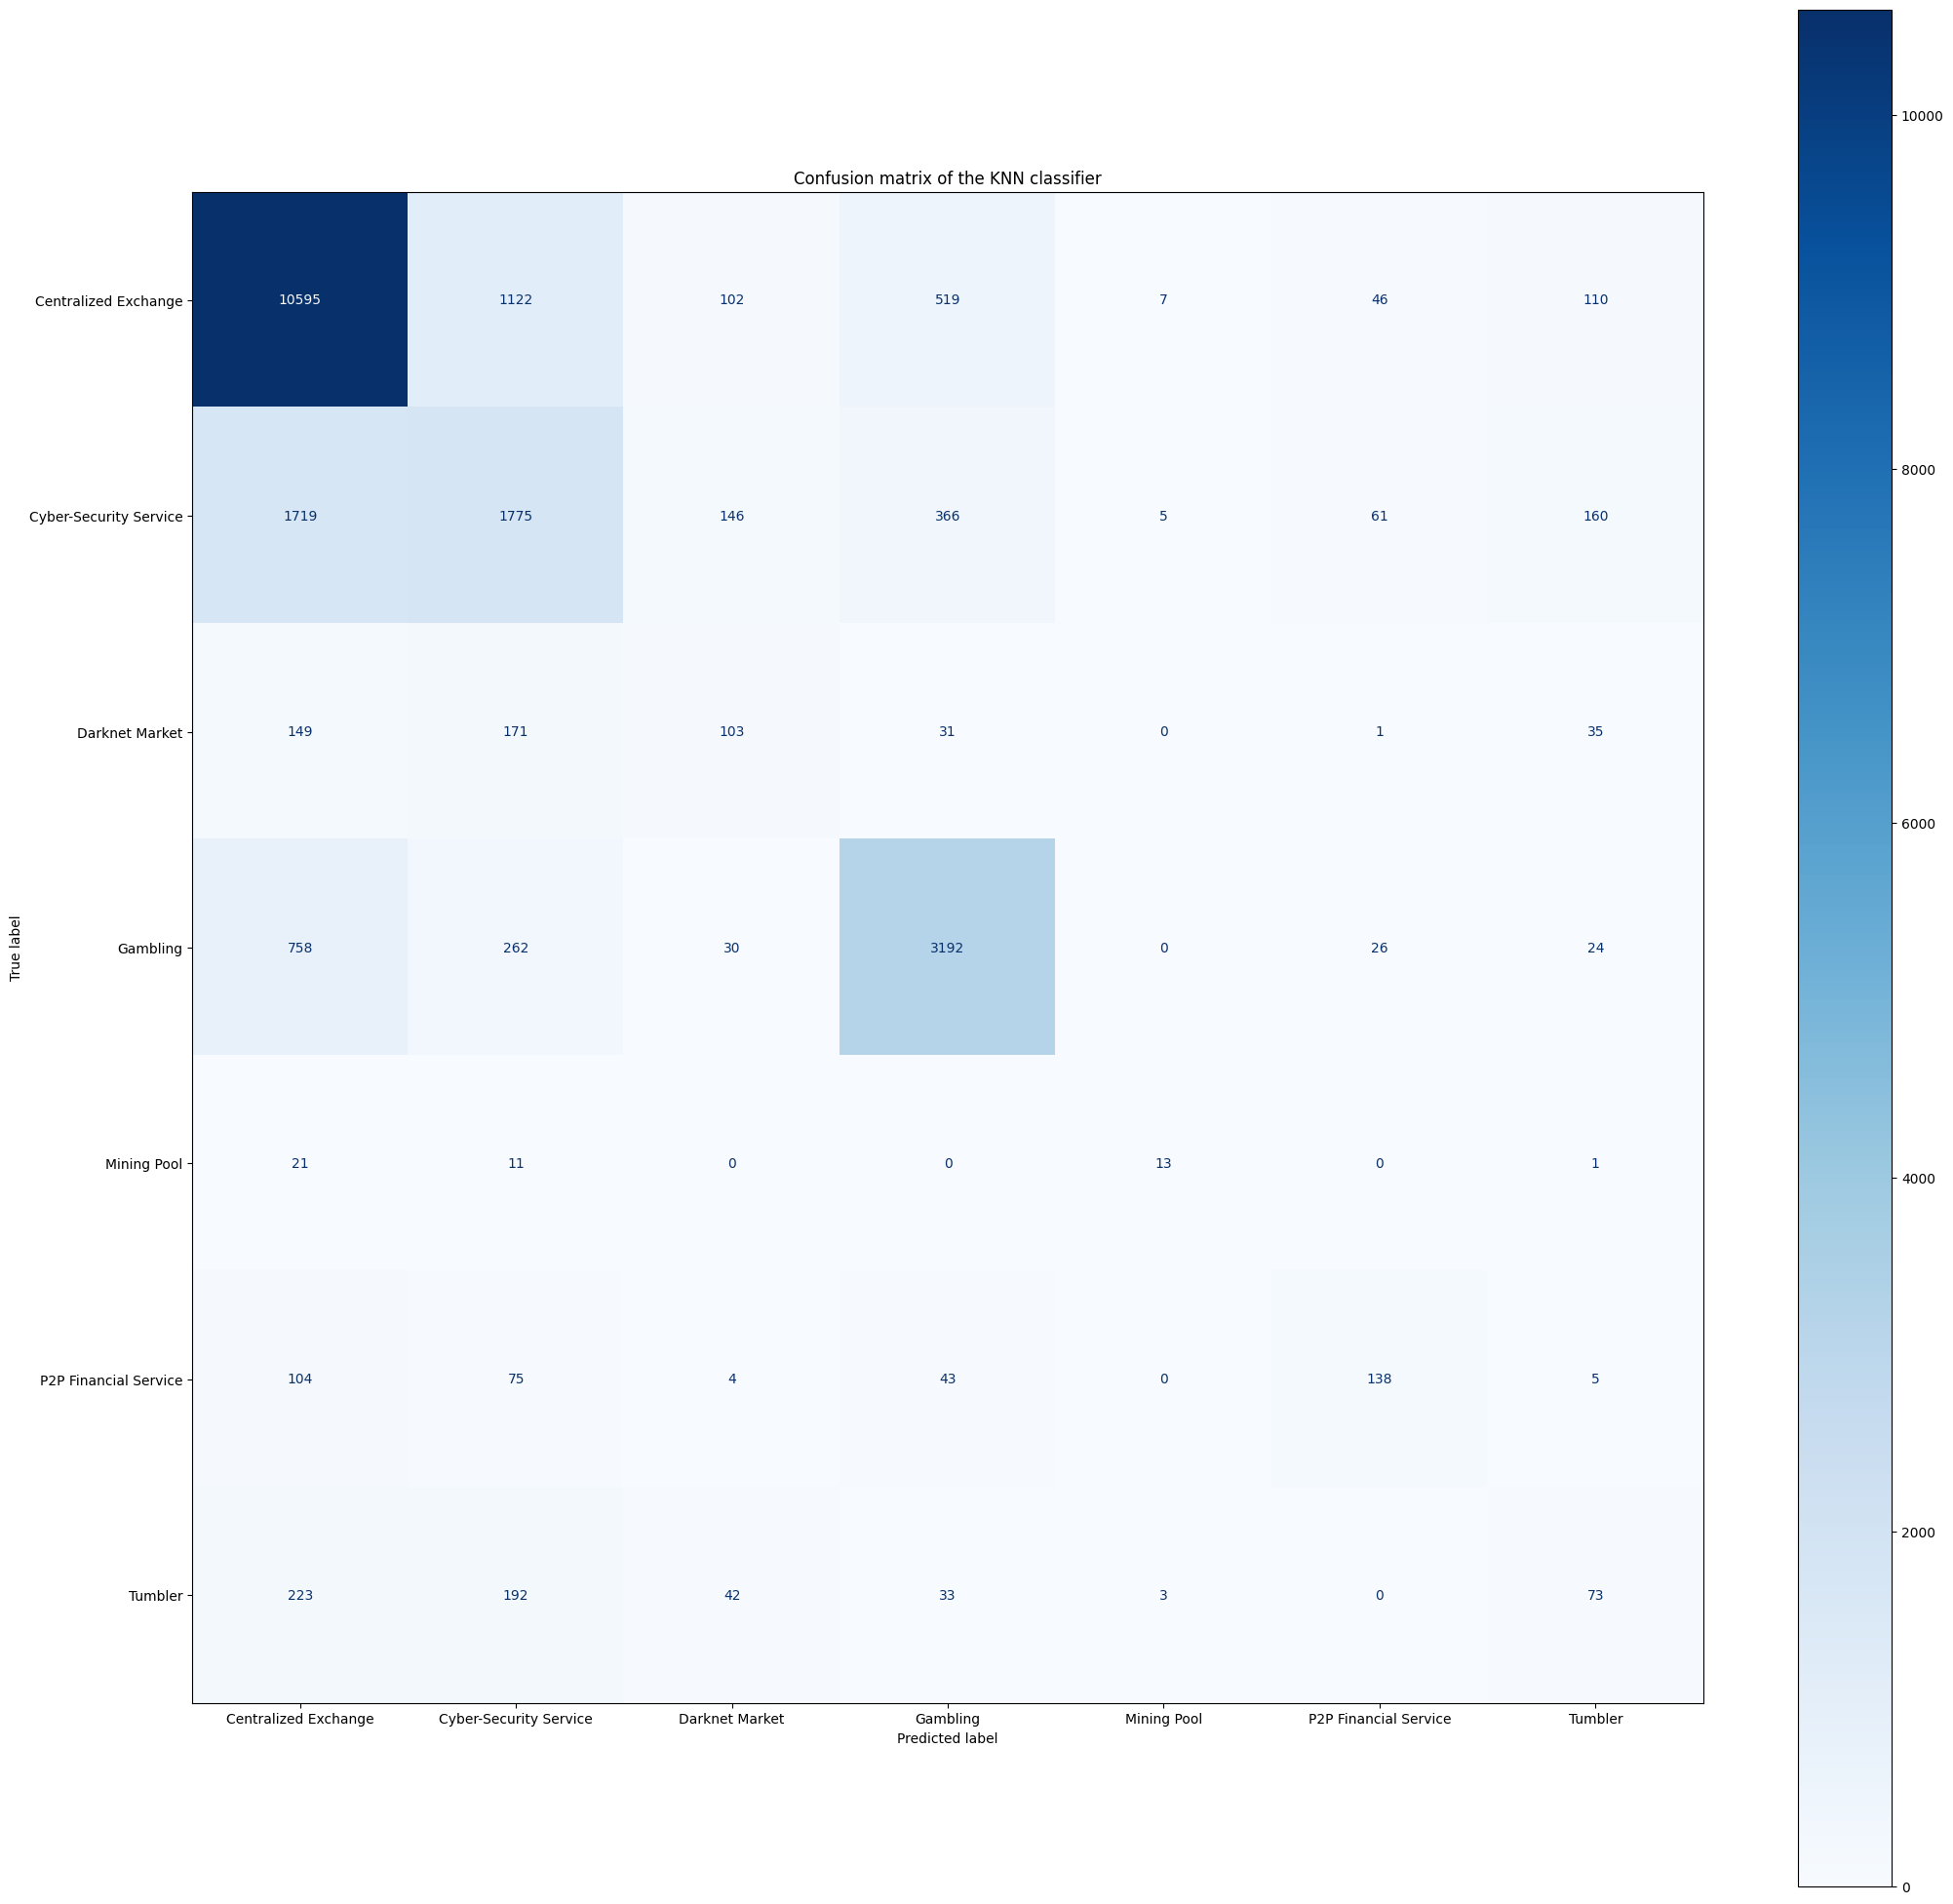

In [177]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the KNN classifier")
disp = ConfusionMatrixDisplay.from_estimator(
    neigh,
    test_features,
    test_labels,
    cmap=plt.cm.Blues,
    ax=ax
)

#### Using XG-Boost

In [207]:
decoded_label_list = ['Centralized Exchange', 'cyber-Security Service', 'Darknet Market', 'Gambling', 'Mining Pool', 'P2P Financial Service', 'Tumbler']

In [166]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', learning_rate=0.5, num_class=7)
xgb_model.fit(train_features, train_labels.astype('category').cat.codes)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=7, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=0, ...)

In [196]:
predicted_labels_xgb = xgb_model.predict(test_features)
encoded_test_labels = test_labels.astype('category').cat.codes

In [197]:
accuracy_score(encoded_test_labels, predicted_labels_xgb)

0.9864864864864865

In [198]:
f1_score(encoded_test_labels, predicted_labels_xgb, average=None)

array([0.9920032 , 0.98004958, 0.96839959, 0.98949335, 1.        ,
       0.97655172, 0.9119442 ])

In [199]:
f1_score(encoded_test_labels, predicted_labels_xgb, average='weighted')

0.9865100932911507

In [200]:
recall_score(encoded_test_labels, predicted_labels_xgb, average=None)

array([0.99232061, 0.98086011, 0.96938776, 0.98741845, 1.        ,
       0.95934959, 0.92402827])

In [201]:
precision_score(encoded_test_labels, predicted_labels_xgb, average=None)

array([0.99168599, 0.97924039, 0.96741344, 0.99157698, 1.        ,
       0.99438202, 0.90017212])

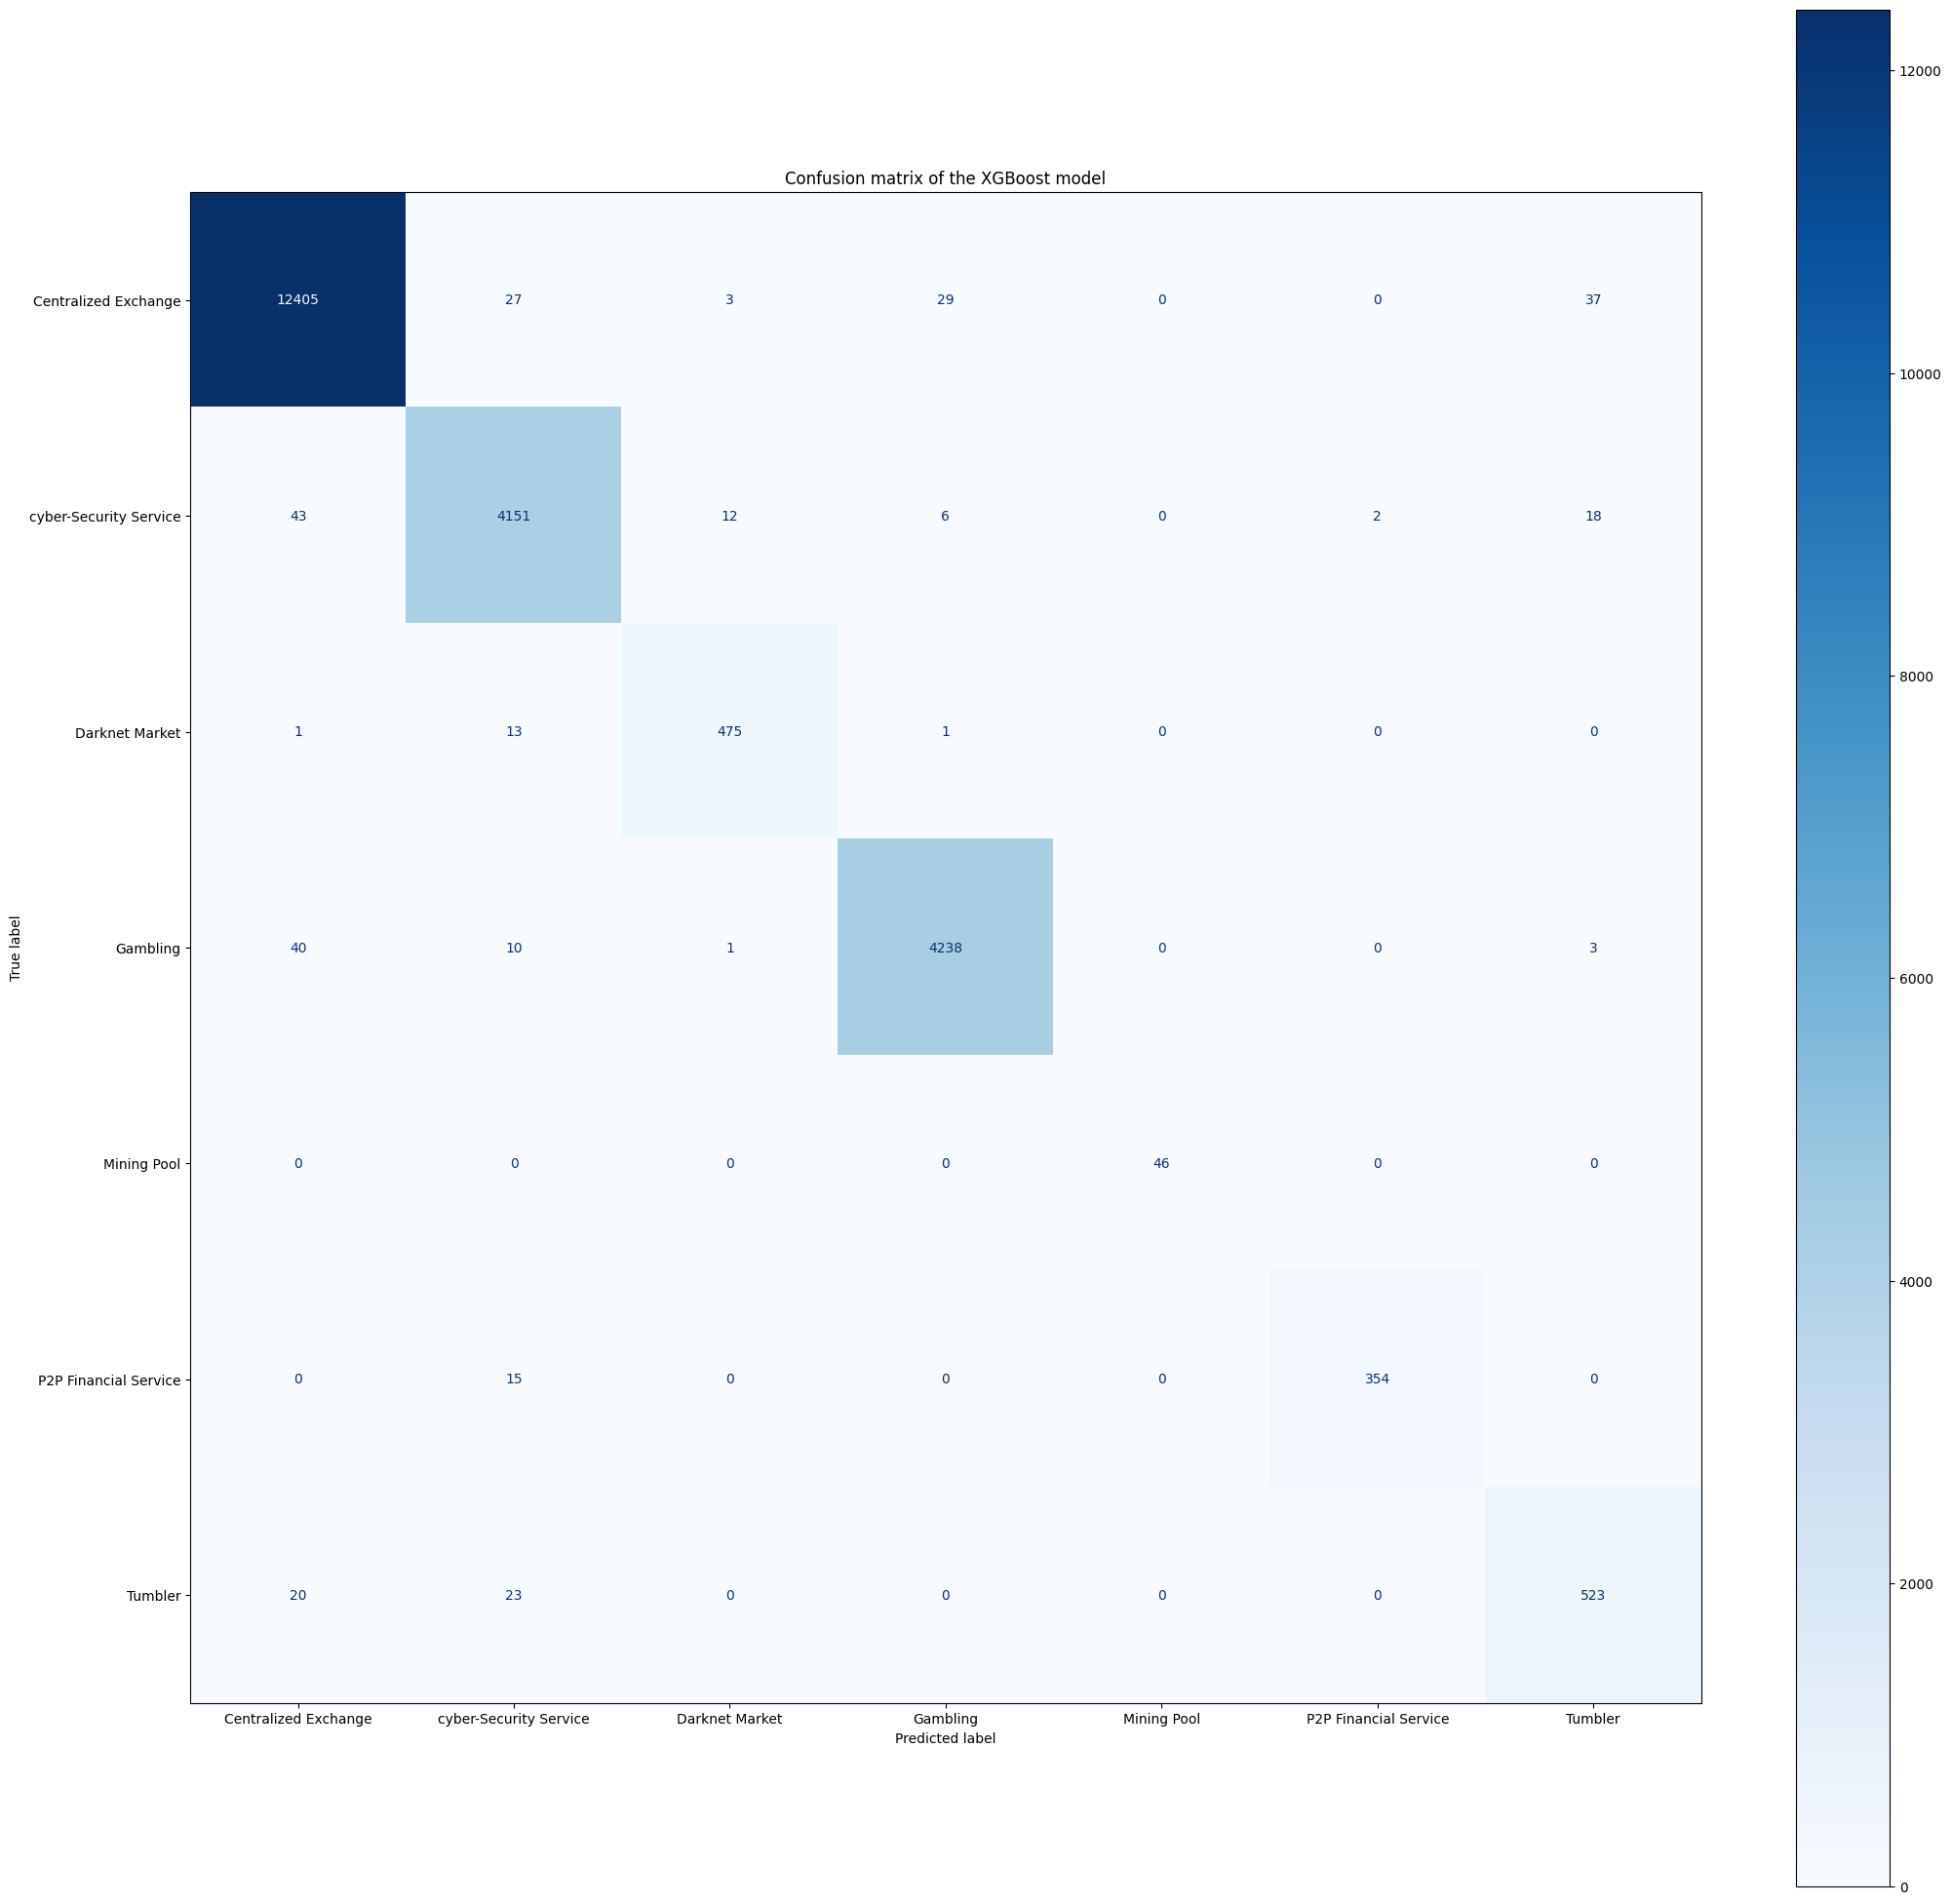

In [211]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Confusion matrix of the XGBoost model")
disp = ConfusionMatrixDisplay.from_predictions(
    encoded_test_labels,
    predicted_labels_xgb,
    cmap=plt.cm.Blues,
    ax=ax
)
x_tick_labels = ax.set_xticklabels(decoded_label_list)
y_tick_labels = ax.set_yticklabels(decoded_label_list)